In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import spyrit.core.torch as st
from scipy.linalg import hadamard

In [2]:
def rht(X, Y, signs=None):
    if signs is None:
        signs = np.random.choice([-1, 1], size=X.shape[0])
    D = np.diag(signs)
    result_X = np.dot(D, X)
    result_Y = np.dot(D, Y)

    tensor_matrix_X = torch.tensor(result_X)
    tensor_matrix_Y = torch.tensor(result_Y)

    # Use natural (Kronecker) order: order=False
    tensor_matrix_X = st.fwht(tensor_matrix_X.T, order=False).T
    tensor_matrix_Y = st.fwht(tensor_matrix_Y.T, order=False).T

    X_out = tensor_matrix_X.numpy() / np.sqrt(X.shape[0])
    Y_out = tensor_matrix_Y.numpy() / np.sqrt(Y.shape[0])
    return X_out, Y_out, signs

In [3]:
def algorithm_for_BHDdot(n,k,p,weight,mu_1,mu_2,var_1,var_2,proportion,random_seed=39):
    m = int(n/k)
    ## 2: Generate our GMM raw data, this (i) is not considered as the part of this scheme algorithm.
    mu_1_vector = np.ones(p) * mu_1
    sigma_1_vector = np.eye(p) * var_1
    mu_2_vector = np.ones(p) * mu_2
    sigma_2_vector = np.eye(p) * var_2
    weight_1 = weight
    data_proportion_1_no_rows = int(n * weight_1)
    data_proportion_2_no_rows = n - data_proportion_1_no_rows
    np.random.seed(random_seed)
    data_1 = np.random.multivariate_normal(mu_1_vector, sigma_1_vector,size=data_proportion_1_no_rows)
    data_2 = np.random.multivariate_normal(mu_2_vector, sigma_2_vector,size=data_proportion_2_no_rows)
    X_raw = np.vstack((data_1, data_2))
    np.random.shuffle(X_raw)
    epsilon = np.random.normal(0,1,size = n)
    beta = np.random.normal(0,1,size = p)
    Y_raw = np.dot(X_raw,beta) + epsilon
    ## 3a: Partition the data equally to k clients.
    X_clients = np.array_split(X_raw, k)
    Y_clients = np.array_split(Y_raw, k)
    ## 3b: draw global Rademacher signs once
    np.random.seed(random_seed)
    global_signs = np.random.choice([-1, 1], size=n)
    ## 4: Apply normalized rht on each client side
    X_rht_clients = []
    Y_rht_clients = []
    for i in range(k):
      start = i * m
      end   = (i+1) * m
      signs_i = global_signs[start:end]
      X_rht, Y_rht, _ = rht(X_clients[i], Y_clients[i].reshape(-1, 1), signs=signs_i)
      X_rht_clients.append(X_rht)
      Y_rht_clients.append(Y_rht)
    ## 5a: Generate a randomized np.index list, the length is 'proportion' * m for each client (but fixed for all of them_meaning the same indices are used for all clients), index range is from 0 to m-1 (inclusive).
    np.random.seed(random_seed)
    selected_indices = np.random.choice(m, size=int(proportion * m), replace=False)
    ## 5b: make this index list to a diagonal matrix, with 1 on the selected indices and 0 elsewhere, so the dimension should be m x m.
    S_matrix = np.zeros((m, m))
    for index in selected_indices:
        S_matrix[index, index] = 1
    ## 6: Use this index matrix S to do on each client: S*H_m*D_i*X_i and S*H_m*D_i*Y_i (this process could be done either by using 5a or 5b, choose one which is faster).
    X_final_clients = []
    Y_final_clients = []
    for i in range(k):
        X_final = np.dot(S_matrix, X_rht_clients[i])
        Y_final = np.dot(S_matrix, Y_rht_clients[i])
        X_final_clients.append(X_final)
        Y_final_clients.append(Y_final)
    ## 7a: concatenate all the clients' final X and Y by columns to recover the dimension of (proportion*n) x p for X and (proportion*n) x 1 for Y.
    X_final_all = np.vstack(X_final_clients)
    Y_final_all = np.vstack(Y_final_clients)
    ## 7b: Compute the kronecker product: H_k ⊗ I_m first (H_k is the normalized hadamard matrix with dimension k xk, I_m is the identity matrix with dimension m x m), then multiply it with the concatenated X and Y from 7a.
    H_k = hadamard(k) / np.sqrt(k)
    I_m = np.eye(m)
    H_k_kron_I_m = np.kron(H_k, I_m)
    X_global = np.dot(H_k_kron_I_m, X_final_all)
    Y_global = np.dot(H_k_kron_I_m, Y_final_all)
    ### 7c: Eliminate the zero rows inside X_global and Y_global to get the final output
    non_zero_row_indices = []
    for i in range(X_global.shape[0]):
        if not np.all(X_global[i, :] == 0):
            non_zero_row_indices.append(i)
    X_global = X_global[non_zero_row_indices, :]
    Y_global = Y_global[non_zero_row_indices, :]
    # 8: Global RHT using another randomized diagonal sign matrix and another randomized sampling matrix S, the intention here is to do global BHDX directly on the raw data for comparision purpose.
    ## Generate a global randomized index 1/0 matrix B_star
    np.random.seed(random_seed)
    selected_indices_global = np.random.choice(n, size=int(proportion * n), replace=False)
    ## Compute the global randomized diagonal sign matrix D_global
    signs_new = np.random.choice([-1, 1], size=n)
    X_rht_global, Y_rht_global, _ = rht(X_raw, Y_raw.reshape(-1, 1), signs=signs_new)
    ## Apply B_star on the global RHT result
    X_global_compare_1_global = X_rht_global[selected_indices_global, :]
    Y_global_compare_1_global = Y_rht_global[selected_indices_global, :]
    ## Directly do sampling on the raw matrix
    selected_indices_global = np.random.choice(n, size=int(proportion * n), replace=False)
    X_raw = X_raw[selected_indices_global, :]
    Y_raw = Y_raw[selected_indices_global].reshape(-1, 1)
    return X_raw, Y_raw, X_global, Y_global, X_global_compare_1_global, Y_global_compare_1_global
## Example usage:
n = 8192*8  # number of samples
k = 8   # number of clients
p = 100   # number of features
proportion = 0.25  # proportion of data to be selected
X_raw, Y_raw, X_transformed, Y_transformed, X_transformed_global, Y_transformed_global = algorithm_for_BHDdot(n, k, p, weight=0.8, mu_1=0, mu_2=5, var_1=1, var_2=10, proportion=proportion, random_seed=39)
print("Shape of raw X:", X_raw.shape)
print("Shape of raw Y:", Y_raw.shape)
print("Shape of transformed X:", X_transformed.shape)
print("Shape of transformed Y:", Y_transformed.shape)
print("Shape of globally transformed X:", X_transformed_global.shape)
print("Shape of globally transformed Y:", Y_transformed_global.shape)
### Check that there is no all-zero rows in all six matrices
def check_no_all_zero_rows(matrix, name):
    for i in range(matrix.shape[0]):
        if np.all(matrix[i, :] == 0):
            print(f"All-zero row found in {name} at row {i}")
            return
    print(f"No all-zero rows in {name}")
check_no_all_zero_rows(X_raw, "X_raw")
check_no_all_zero_rows(Y_raw, "Y_raw")
check_no_all_zero_rows(X_transformed, "X_transformed")
check_no_all_zero_rows(Y_transformed, "Y_transformed")
check_no_all_zero_rows(X_transformed_global, "X_transformed_global")
check_no_all_zero_rows(Y_transformed_global, "Y_transformed_global")

Shape of raw X: (16384, 100)
Shape of raw Y: (16384, 1)
Shape of transformed X: (16384, 100)
Shape of transformed Y: (16384, 1)
Shape of globally transformed X: (16384, 100)
Shape of globally transformed Y: (16384, 1)
No all-zero rows in X_raw
No all-zero rows in Y_raw
No all-zero rows in X_transformed
No all-zero rows in Y_transformed
No all-zero rows in X_transformed_global
No all-zero rows in Y_transformed_global


In [4]:
max_diff_X = np.max(np.abs(X_transformed - X_transformed_global))
max_diff_Y = np.max(np.abs(Y_transformed - Y_transformed_global))
print("max |ΔX| =", max_diff_X)
print("max |ΔY| =", max_diff_Y)

max |ΔX| = 18.093452341206433
max |ΔY| = 166.92035300288597


Then it is verified that these two pairs of transformed matrix are totally different, one orignates from our new algorithm, one from direct BHDX to apply directly on X_raw matrix.

**Intention of this notbook is to show if these two method in general contribute to our research here, if success. Then our algorithm is just worth fighting for. Just like our life.**

In [5]:
def partition_matrix_not_necessary_divisable(X,Y,k):
    """
    Partition the rows of matrix X across k machines uniformly with equal probability.
    Each machine will receive a sub-matrix of X and the corresponding sub-vector of Y.

    Parameters:
    X (numpy.ndarray): The input matrix to be partitioned (n rows, m columns).
    Y (numpy.ndarray): The output vector to be partitioned (n rows, 1 column).
    k (int): The number of machines.

    Returns:
    list of numpy.ndarray: A list of sub-matrices, each assigned to a machine.
    """
    # Get the number of rows in the matrix
    n = X.shape[0]
    
    # Create an array of row indices (0 to n-1)
    indices = np.arange(n)
    
    # Shuffle the indices randomly to ensure each row has equal probability
    np.random.shuffle(indices)
    
    # Calculate the base size of each partition and the remainder
    part_size = n // k  # Base number of rows per machine
    remainder = n % k   # Extra rows to distribute
    
    # Split the indices into k parts
    parts = []
    start = 0
    for i in range(k):
        # The first 'remainder' machines get one extra row
        end = start + part_size + (1 if i < remainder else 0)
        parts.append(indices[start:end])
        start = end
    
    # Create sub-matrices for each machine using the partitioned indices
    sub_matrices = [X[part] for part in parts]
    sub_matrices_Y = [Y[part] for part in parts]
    
    return sub_matrices, sub_matrices_Y

In [6]:
#Expected Efficiency,DELTA^2 = 1
def MSE(X,A,delta = 1):
    return (delta**2)*np.trace(np.dot(np.linalg.inv(np.dot(X.T,X)),np.dot(A.T,A)))

In [7]:
def average_MSE_expectation_not_divisable(X,Y,k,delta = 1):
    sub_matrices,sub_target = partition_matrix_not_necessary_divisable(X,Y,k)
    mse_pre = 0
    for i in range(k):
        X_i = sub_matrices[i]
        Y_i = sub_target[i]
        X_i = np.array(X_i)
        Y_i = np.array(Y_i)
        MSE_gained = MSE(X_i,np.eye(X_i.shape[1]),delta)
        MSE_gained = MSE_gained * ((1/k)**2)
        mse_pre += MSE_gained
    return mse_pre
def Relative_Efficiency_not_divisable(MSE_ols,X,Y,k,delta=1):
    mse = average_MSE_expectation_not_divisable(X,Y,k,delta)
    mse = MSE_ols/mse
    mse = round(mse,4)
    return mse

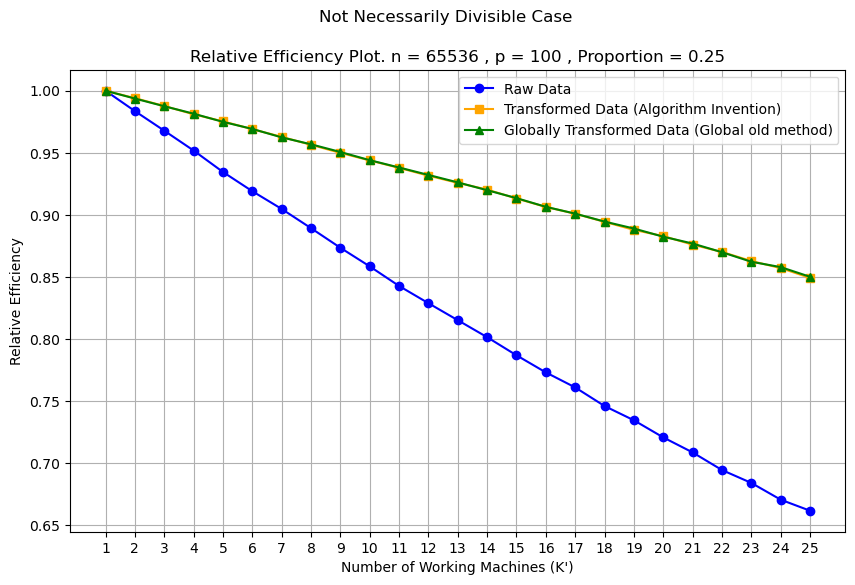

In [8]:
### First big plot: not necessarily divisible by k Case.
### Plot scheme: relative efficiency on X_raw and Y_raw; relative efficiency on X_transformed and Y_transformed; relative efficiency on X_transformed_global and Y_transformed_global.
### Remark: The working machine number K_prime now is a new variable, it could be any integer, even odd numbers.
### Method: In a for loop with number count = i+1 to defined K_prime, calculate relative efficiency E and add to a list, finally to plot relative efficiency as a line.
### Begin plot: don't define functions again, just plot with the previous defined functions
Expected_Efficiency_raw = []
Expected_Efficiency_transformed = []
Expected_Efficiency_transformed_global = []
K_prime = 25  # Define the maximum number of working machines
for i in range(K_prime):
    k_current = i + 1  # Current number of working machines
    RE_raw = Relative_Efficiency_not_divisable(MSE_ols=MSE(X_raw,np.eye(X_raw.shape[1])),X=X_raw,Y=Y_raw,k=k_current,delta=1)
    RE_transformed = Relative_Efficiency_not_divisable(MSE_ols=MSE(X_transformed,np.eye(X_transformed.shape[1])),X=X_transformed,Y=Y_transformed,k=k_current,delta=1)
    RE_transformed_global = Relative_Efficiency_not_divisable(MSE_ols=MSE(X_transformed_global,np.eye(X_transformed_global.shape[1])),X=X_transformed_global,Y=Y_transformed_global,k=k_current,delta=1)
    Expected_Efficiency_raw.append(RE_raw)
    Expected_Efficiency_transformed.append(RE_transformed)
    Expected_Efficiency_transformed_global.append(RE_transformed_global)
# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(range(1, K_prime + 1), Expected_Efficiency_raw, marker='o', label='Raw Data', color='blue')
plt.plot(range(1, K_prime + 1), Expected_Efficiency_transformed, marker='s', label='Transformed Data (Algorithm Invention)', color='orange')
plt.plot(range(1, K_prime + 1), Expected_Efficiency_transformed_global, marker='^', label='Globally Transformed Data (Global old method)', color='green')
plt.title('Relative Efficiency Plot. n = {} , p = {} , Proportion = {}'.format(n,p,proportion))
plt.suptitle('Not Necessarily Divisible Case')
plt.xlabel('Number of Working Machines (K\')')
plt.ylabel('Relative Efficiency')
plt.xticks(range(1, K_prime + 1))
plt.legend()
plt.grid()
plt.show()

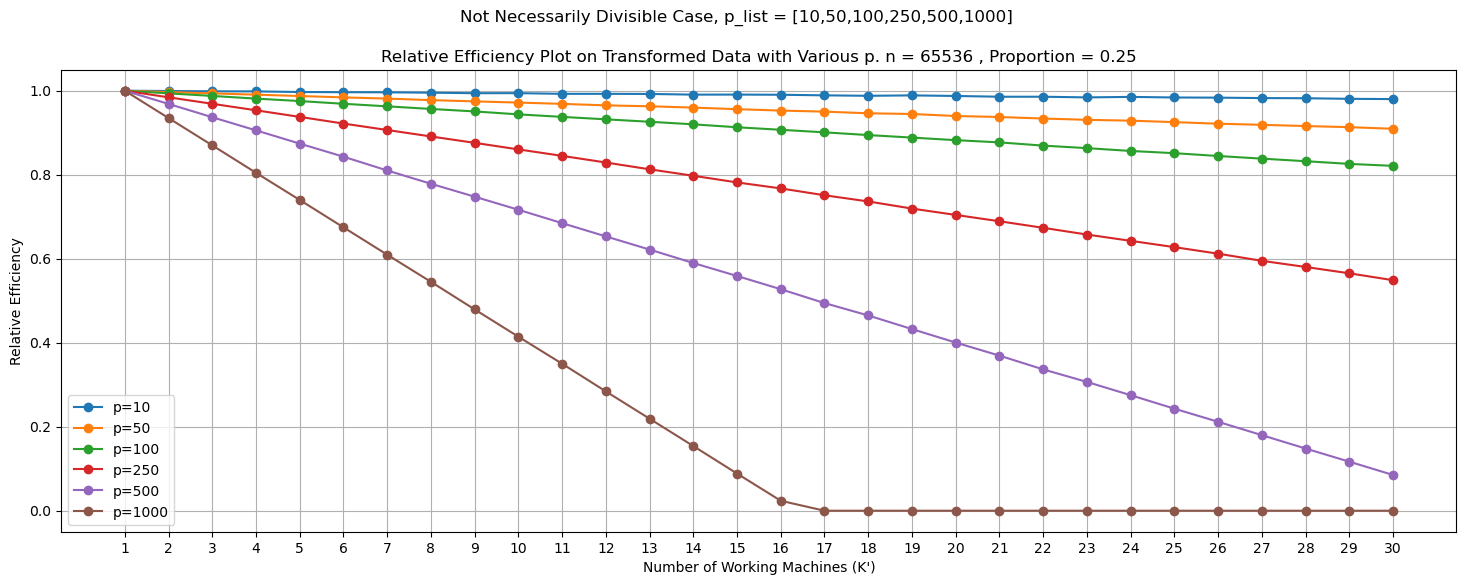

In [9]:
plt.figure(figsize=(18,6))
p_list = [10,50,100,250,500,1000]
for p in p_list:
    X_raw, Y_raw, X_transformed, Y_transformed, X_transformed_global, Y_transformed_global = algorithm_for_BHDdot(n, k, p, weight=0.8, mu_1=0, mu_2=5, var_1=1, var_2=10, proportion=proportion, random_seed=39)
    Expected_Efficiency_transformed = []
    K_prime = 30  # Define the maximum number of working machines
    for i in range(K_prime):
        k_current = i + 1  # Current number of working machines
        RE_transformed = Relative_Efficiency_not_divisable(MSE_ols=MSE(X_transformed,np.eye(X_transformed.shape[1])),X=X_transformed,Y=Y_transformed,k=k_current,delta=1)
        Expected_Efficiency_transformed.append(RE_transformed)
    plt.plot(range(1, K_prime + 1), Expected_Efficiency_transformed, marker='o', label='p={}'.format(p))
plt.title('Relative Efficiency Plot on Transformed Data with Various p. n = {} , Proportion = {}'.format(n,proportion))
plt.suptitle('Not Necessarily Divisible Case, p_list = [10,50,100,250,500,1000]')
plt.xlabel('Number of Working Machines (K\')')
plt.ylabel('Relative Efficiency')
plt.xticks(range(1, K_prime + 1))
plt.legend()
plt.grid()
plt.show()